In [1]:
import os
import json
import pandas as pd

word_dictionary = pd.read_csv("../data/raw/word/word_dictionary.csv", sep=',')

word_level_dict = word_dictionary.set_index('Word')['Level'].to_dict()

def json_files_to_content_list(folder_path):
    all_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8-sig') as f:
                try:
                    json_data = json.load(f)
                    extracted_data = extract_columns_from_json(json_data)
                    all_data.extend(extracted_data)
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON from file {filename}: {e}")
    
    return all_data

def extract_columns_from_json(json_data):
    extracted_data = []
    if 'imageInfo' in json_data:
        isbn = json_data['isbn']
        for item in json_data['imageInfo']:
            src_text_id = item.get('srcTextID', "")
            src_text = item.get("srcText", "")
            src_image_file = item.get('srcImageFile', "")
            image_caption_info = item.get("imageCaptionInfo", {})
            image_caption = image_caption_info.get("imageCaption", "")
            classification = image_caption_info.get("classification", "")
            
            extracted_data.append({
                "isbn": isbn,
                "textID": src_text_id,
                "classification": classification,
                "text": src_text,
                "imageFile": 'https://eglubucket.s3.amazonaws.com/images/'+src_image_file,
                "imageCaption": image_caption
            })
    return extracted_data

# JSON 파일 경로 설정 및 데이터 추출
folder_path_pre = "C:/workspace/project_bigdata/data/picture_data/preschool"
folder_path_123 = "C:/workspace/project_bigdata/data/picture_data/school_123"
folder_path_456 = "C:/workspace/project_bigdata/data/picture_data/school_456"

picturepre_data = json_files_to_content_list(folder_path_pre)
picture123_data = json_files_to_content_list(folder_path_123)
picture456_data = json_files_to_content_list(folder_path_456)

In [2]:
# DataFrame 생성 및 데이터 추가
picturepre = pd.DataFrame(picturepre_data)
picture123 = pd.DataFrame(picture123_data)
picture456 = pd.DataFrame(picture456_data)

def calculate_word_metrics(content, word_level_dict):
    words = content.split()
    word_count = len(words)
    length = len(content)
    
    levels = [word_level_dict[word] for word in words if word in word_level_dict]
    
    if levels:
        word_avg = sum(levels) / len(levels)
        word_high = max(levels)
    else:
        word_avg = 0
        word_high = 0
    
    return word_count, word_avg, word_high, length

picturepre[['word_count', 'word_avg', 'word_hard', 'length']] = picturepre['text'].apply(
    lambda content: pd.Series(calculate_word_metrics(content, word_level_dict))
)
picture123[['word_count', 'word_avg', 'word_hard', 'length']] = picture123['text'].apply(
    lambda content: pd.Series(calculate_word_metrics(content, word_level_dict))
)
picture456[['word_count', 'word_avg', 'word_hard', 'length']] = picture456['text'].apply(
    lambda content: pd.Series(calculate_word_metrics(content, word_level_dict))
)

In [3]:
picturepre = picturepre[picturepre['word_hard'] > 0].reset_index(drop=True)
picture123 = picture123[picture123['word_hard'] > 0].reset_index(drop=True)
picture456 = picture456[picture456['word_hard'] > 0].reset_index(drop=True)

In [4]:
picturepre.to_csv("../data/processed/story/detail/picturepre.csv", sep=',', encoding='utf-8-sig', index=False)
picture123.to_csv("../data/processed/story/detail/picture123.csv", sep=',', encoding='utf-8-sig', index=False)
picture456.to_csv("../data/processed/story/detail/picture456.csv", sep=',', encoding='utf-8-sig', index=False)

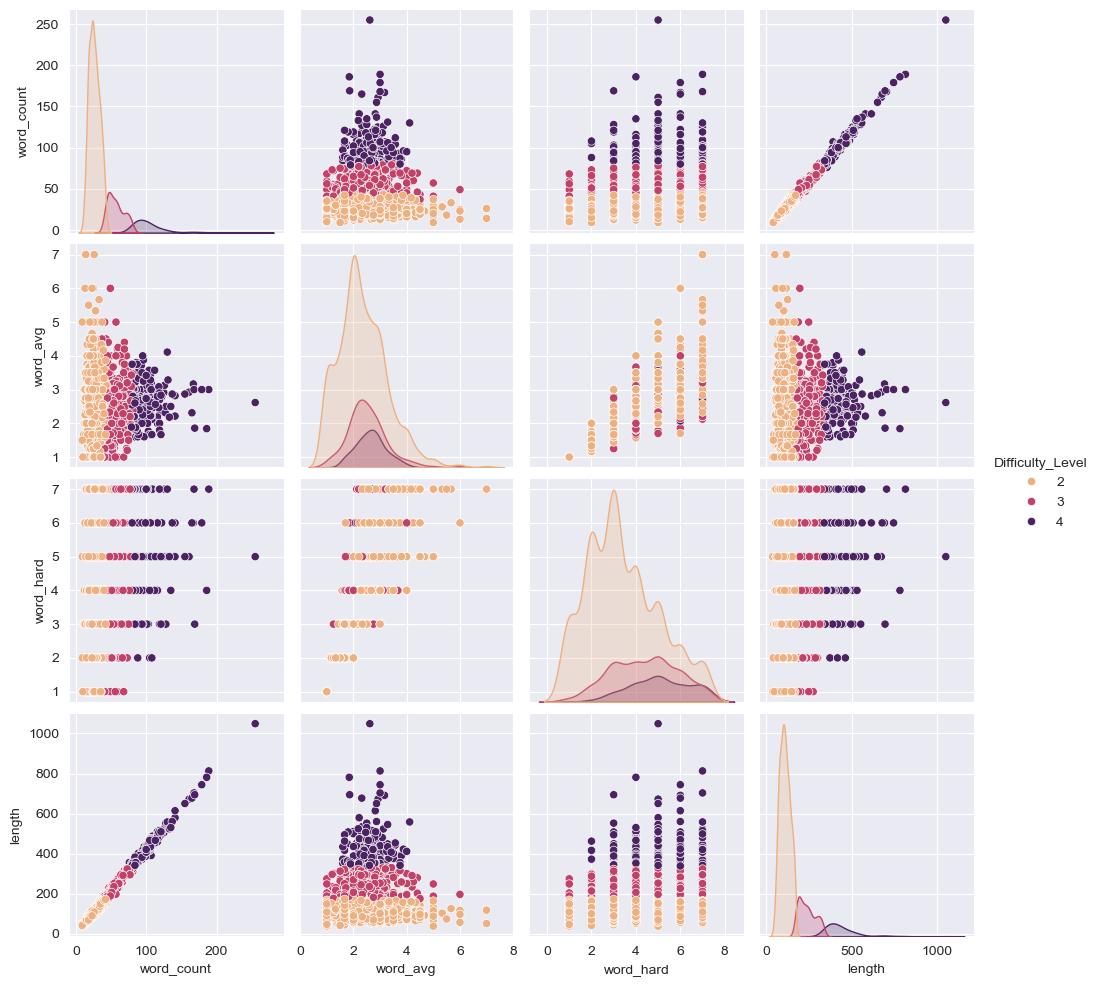

Saved difficulty levels to ../data/processed/story/detail/picture123_level.csv


In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# K-means 적용
n_clusters = 3 
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
picture123['Cluster'] = kmeans.fit_predict(picture123[['word_count', 'word_avg', 'word_hard', 'length']])

# word_high 평균값이 높은 클러스터부터 높은 난이도로 분류
cluster_avg = picture123.groupby('Cluster')['word_hard'].mean().sort_values()
cluster_avg_rank = cluster_avg.rank().astype(int)+1
difficulty_mapping = {cluster: rank for cluster, rank in zip(cluster_avg.index, cluster_avg_rank)}
picture123['Difficulty_Level'] = picture123['Cluster'].map(difficulty_mapping)

# 시각화
features = ['word_count', 'word_avg', 'word_hard', 'length', 'Difficulty_Level']
sns_plot = sns.pairplot(picture123[features], hue='Difficulty_Level', palette='flare')
image_path = "../data/processed/story/detail/picture123_level_pairplot.png"
sns_plot.savefig(image_path)
plt.show()


file_path = "../data/processed/story/detail/picture123_level.csv"
picture123.to_csv(file_path, index=False, sep=',', encoding='utf-8-sig')
print(f"Saved difficulty levels to {file_path}")

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


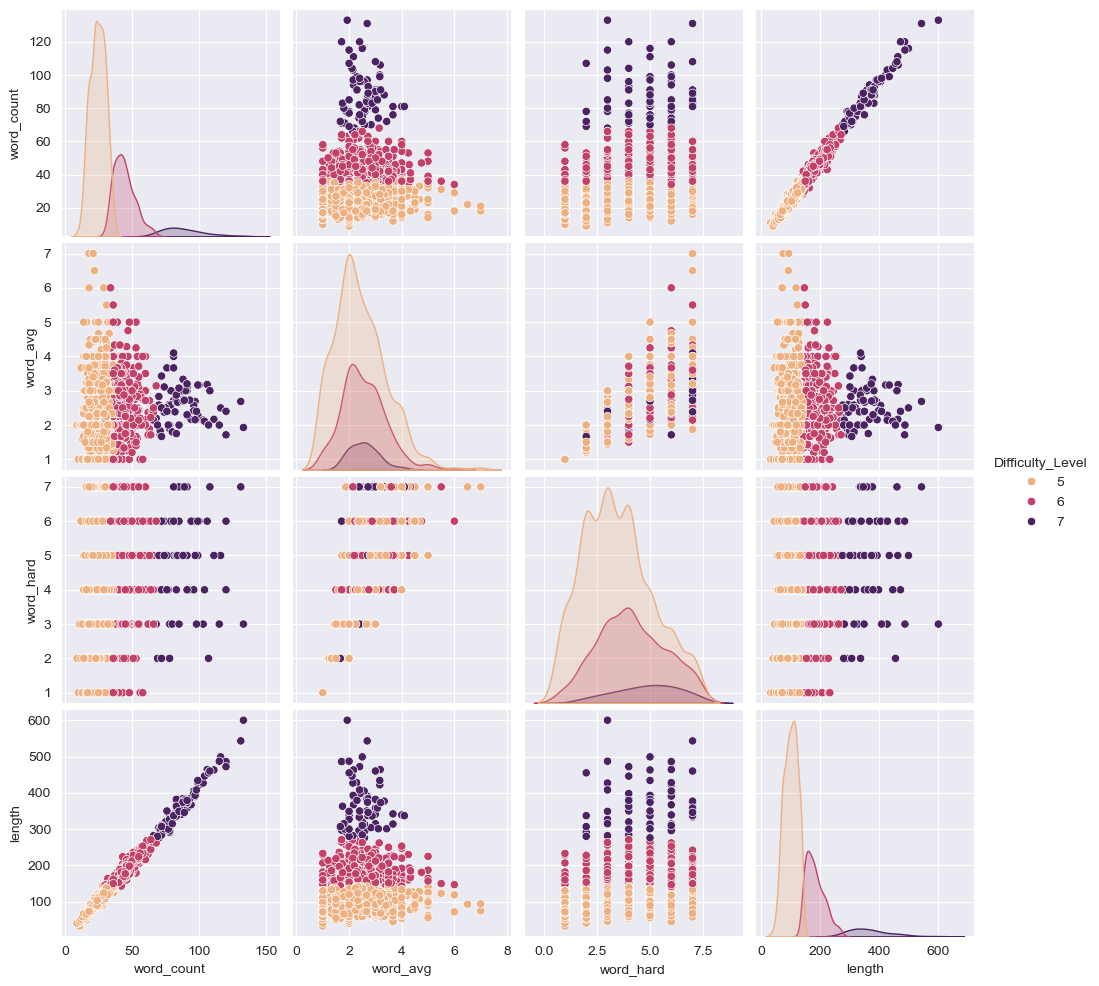

Saved difficulty levels to ../data/processed/story/detail/picture456_level.csv


In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# K-means 적용
n_clusters = 3 
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
picture456['Cluster'] = kmeans.fit_predict(picture456[['word_count', 'word_avg', 'word_hard', 'length']])

# word_high 평균값이 높은 클러스터부터 높은 난이도로 분류
cluster_avg = picture456.groupby('Cluster')['word_hard'].mean().sort_values()
cluster_avg_rank = cluster_avg.rank().astype(int)+4
difficulty_mapping = {cluster: rank for cluster, rank in zip(cluster_avg.index, cluster_avg_rank)}
picture456['Difficulty_Level'] = picture456['Cluster'].map(difficulty_mapping)

# 시각화
features = ['word_count', 'word_avg', 'word_hard', 'length', 'Difficulty_Level']
sns_plot = sns.pairplot(picture456[features], hue='Difficulty_Level', palette='flare')
image_path = "../data/processed/story/detail/picture456_level_pairplot.png"
sns_plot.savefig(image_path)
plt.show()


file_path = "../data/processed/story/detail/picture456_level.csv"
picture456.to_csv(file_path, index=False, sep=',', encoding='utf-8-sig')
print(f"Saved difficulty levels to {file_path}")

In [7]:
picturepre['Cluster'] = 0
picturepre['Difficulty_Level'] = 1

print(picturepre)

               isbn textID classification  \
0     9788959991051  57122           의사소통   
1     9788959991129  56363           의사소통   
2     9788959991136  58443           의사소통   
3     9788959991136  58446           의사소통   
4     9788959991143  60456           의사소통   
...             ...    ...            ...   
1526  9791165433154  27687        신체운동_건강   
1527  9791165433154  27698        신체운동_건강   
1528  9791165433154   3688        신체운동_건강   
1529  9791165433154   3690        신체운동_건강   
1530  9791165433161   3225        신체운동_건강   

                                                   text  \
0     깜짝 놀란 베키는 살금살금 소리가 나는 곳으로 가 보았어요. 앗! 그런데 입이 길쭉...   
1     이번에는 나무에 노란 바나나가 주렁주렁 열려 있어요. “와, 향긋한 바나나다!” 위...   
2     그러자 주인 도깨비는 날쌘 독수리로 변신해 쫓아와요! “헉헉, 더 이상은 안 되겠어...   
3     “죄송해요. 배가 고파서 그랬어요.” 엘비가 사과를 하자 주인 도깨비가 말했어요. ...   
4                해바라기도 마찬가지였어요. “땅꼬마 꿀벌! 너에게 줄 꿀은 없단다!”   
...                                                 ...   
1526  더비는 자연재해가 일어나는 이유가 궁금했어요. 그래서 책을 찾아 자세히 

In [8]:
picture = pd.concat([picturepre, picture123, picture456], ignore_index=True)
picture.to_csv("../data/processed/story/result/picture_all.csv", sep=',', encoding='utf-8-sig', index=False)

In [9]:
print(picture)

               isbn textID classification  \
0     9788959991051  57122           의사소통   
1     9788959991129  56363           의사소통   
2     9788959991136  58443           의사소통   
3     9788959991136  58446           의사소통   
4     9788959991143  60456           의사소통   
...             ...    ...            ...   
4643  9791165433475  35178        신체운동_건강   
4644  9791165433758   3150        신체운동_건강   
4645  9791165433758  36566        신체운동_건강   
4646  9791165433758  36581        신체운동_건강   
4647  9791165433765  47615        신체운동_건강   

                                                   text  \
0     깜짝 놀란 베키는 살금살금 소리가 나는 곳으로 가 보았어요. 앗! 그런데 입이 길쭉...   
1     이번에는 나무에 노란 바나나가 주렁주렁 열려 있어요. “와, 향긋한 바나나다!” 위...   
2     그러자 주인 도깨비는 날쌘 독수리로 변신해 쫓아와요! “헉헉, 더 이상은 안 되겠어...   
3     “죄송해요. 배가 고파서 그랬어요.” 엘비가 사과를 하자 주인 도깨비가 말했어요. ...   
4                해바라기도 마찬가지였어요. “땅꼬마 꿀벌! 너에게 줄 꿀은 없단다!”   
...                                                 ...   
4643  혹부리 영감은 떡국뿐 아니라, 설에 마시는 맑은 술인 세주와 약과, 강정